In [27]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from dotenv import load_dotenv
from datetime import datetime
import pandas as pd
import os

# Keys
load_dotenv()
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

stock_client = StockHistoricalDataClient(api_key=API_KEY,  secret_key=SECRET_KEY)

request_params = StockBarsRequest(symbol_or_symbols=["AAPL"], timeframe=TimeFrame.Day, start=datetime(2022, 3, 1), end=datetime(2025, 3, 1))

bars = stock_client.get_stock_bars(request_params)

df = pd.DataFrame(bars["AAPL"])

# Ta bort tuple-formatet och extrahera endast värdena
df = df.map(lambda x: x[1])  # Tar bara det andra elementet i tuple:n

df.columns = ["symbol", "timestamp", "open", "high", "low", "close", "volume", "trade_count", "vwap"]

display(df)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2022-03-01 05:00:00+00:00,164.695,166.60,161.97,163.20,90604732.0,749658.0,164.104707
1,AAPL,2022-03-02 05:00:00+00:00,164.390,167.36,162.95,166.56,88692844.0,668264.0,165.912587
2,AAPL,2022-03-03 05:00:00+00:00,168.470,168.91,165.55,166.23,82418843.0,651766.0,166.903132
3,AAPL,2022-03-04 05:00:00+00:00,164.490,165.55,162.10,163.17,91169381.0,742704.0,163.361005
4,AAPL,2022-03-07 05:00:00+00:00,163.360,165.02,159.04,159.30,107385155.0,847060.0,161.243957
...,...,...,...,...,...,...,...,...,...
748,AAPL,2025-02-24 05:00:00+00:00,244.925,248.86,244.42,247.10,51326396.0,593130.0,247.302823
749,AAPL,2025-02-25 05:00:00+00:00,248.000,250.00,244.91,247.04,48013272.0,574045.0,247.548096
750,AAPL,2025-02-26 05:00:00+00:00,244.330,244.98,239.13,240.36,44433564.0,557242.0,241.664944
751,AAPL,2025-02-27 05:00:00+00:00,239.410,242.46,237.06,237.30,41153639.0,503479.0,239.443587


In [28]:
# Ränka ut tekniska signaler

# SMA - Enkel glidande medelvärde
df["SMA_50"] = df["close"].rolling(window=50).mean()  # 50-dagars SMA
df["SMA_200"] = df["close"].rolling(window=200).mean()  # 200-dagars SMA

# RSI - Relative Strength Index
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI_14"] = calculate_rsi(df["close"])

# Visa de senaste raderna
print(df.tail())


    symbol                 timestamp     open    high     low   close  \
748   AAPL 2025-02-24 05:00:00+00:00  244.925  248.86  244.42  247.10   
749   AAPL 2025-02-25 05:00:00+00:00  248.000  250.00  244.91  247.04   
750   AAPL 2025-02-26 05:00:00+00:00  244.330  244.98  239.13  240.36   
751   AAPL 2025-02-27 05:00:00+00:00  239.410  242.46  237.06  237.30   
752   AAPL 2025-02-28 05:00:00+00:00  236.950  242.09  230.20  241.84   

         volume  trade_count        vwap    SMA_50    SMA_200     RSI_14  
748  51326396.0     593130.0  247.302823  240.6972  224.71240  80.062992  
749  48013272.0     574045.0  247.548096  240.6826  225.03560  76.350851  
750  44433564.0     557242.0  241.664944  240.5600  225.32370  61.821996  
751  41153639.0     503479.0  239.443587  240.3468  225.58735  55.717489  
752  56833360.0     572585.0  239.403148  240.2210  225.88130  70.516893  


In [29]:
# Aggera på signalerna

# Skapa en ny kolumn för signaler
df["Signal"] = 0  # 0 = Ingen position, 1 = Köp, -1 = Sälj

# Köp-signal (Korsar över SMA 50 & RSI < 30)
df.loc[(df["close"] > df["SMA_50"]) & (df["RSI_14"] < 30), "Signal"] = 1  

# Sälj-signal (Korsar under SMA 50 & RSI > 70)
df.loc[(df["close"] < df["SMA_50"]) & (df["RSI_14"] > 70), "Signal"] = -1  

# Visa signalerna
print(df[["timestamp", "close", "SMA_50", "RSI_14", "Signal"]].tail(20))  # Sista 20 dagarna

                    timestamp   close    SMA_50     RSI_14  Signal
733 2025-01-31 05:00:00+00:00  236.00  240.2280  49.132830       0
734 2025-02-03 05:00:00+00:00  228.01  240.2278  44.142988       0
735 2025-02-04 05:00:00+00:00  232.80  240.3182  49.587771       0
736 2025-02-05 05:00:00+00:00  232.47  240.3876  44.996294       0
737 2025-02-06 05:00:00+00:00  233.22  240.4816  55.498891       0
738 2025-02-07 05:00:00+00:00  227.63  240.4368  47.600572       0
739 2025-02-10 05:00:00+00:00  227.65  240.3324  56.014406       0
740 2025-02-11 05:00:00+00:00  232.62  240.2836  59.674224       0
741 2025-02-12 05:00:00+00:00  236.87  240.3224  63.340739       0
742 2025-02-13 05:00:00+00:00  241.53  240.4064  67.592419       0
743 2025-02-14 05:00:00+00:00  244.60  240.5066  64.955357       0
744 2025-02-18 05:00:00+00:00  244.47  240.5430  57.571324       0
745 2025-02-19 05:00:00+00:00  244.87  240.5802  56.834532       0
746 2025-02-20 05:00:00+00:00  245.83  240.6360  60.430380    

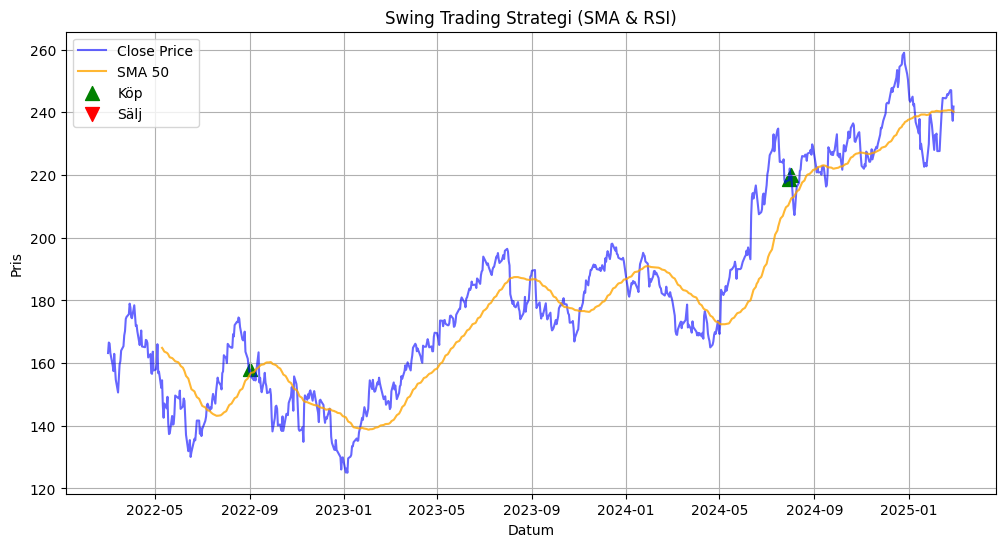

In [33]:
import matplotlib.pyplot as plt

# Skapa en figur
plt.figure(figsize=(12,6))

# Plotta pris och SMA 50
plt.plot(df["timestamp"], df["close"], label="Close Price", color="blue", alpha=0.6)
plt.plot(df["timestamp"], df["SMA_50"], label="SMA 50", color="orange", alpha=0.8)

# Plotta köp- och säljsignaler
plt.scatter(df[df["Signal"] == 1]["timestamp"], df[df["Signal"] == 1]["close"], label="Köp", marker="^", color="green", alpha=1, s=100)
plt.scatter(df[df["Signal"] == -1]["timestamp"], df[df["Signal"] == -1]["close"], label="Sälj", marker="v", color="red", alpha=1, s=100)

# Titel och etiketter
plt.title("Swing Trading Strategi (SMA & RSI)")
plt.xlabel("Datum")
plt.ylabel("Pris")
plt.legend()
plt.grid()
plt.show()


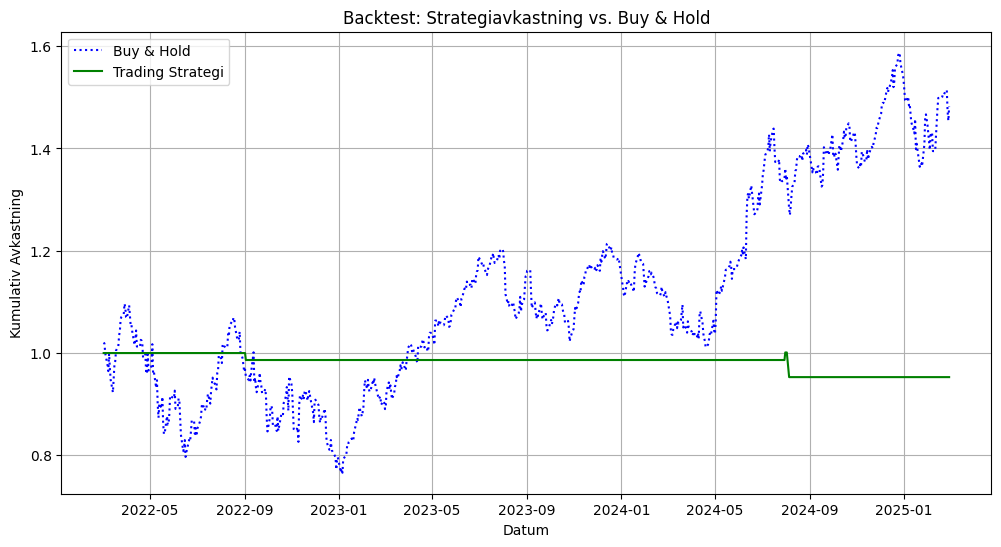

Buy & Hold Slutvärde: 1.48x
Strategi Slutvärde: 0.95x


In [31]:
# Skapa en kolumn för avkastning
df["Returns"] = df["close"].pct_change()

# Skapa en kolumn för strategiavkastning (köper och säljer baserat på signaler)
df["Strategy Returns"] = df["Returns"] * df["Signal"].shift(1)  # Shift för att ta signalen från föregående dag

# Beräkna den kumulativa avkastningen
df["Cumulative Market"] = (1 + df["Returns"]).cumprod()
df["Cumulative Strategy"] = (1 + df["Strategy Returns"]).cumprod()

# Plotta avkastningen
plt.figure(figsize=(12,6))
plt.plot(df["timestamp"], df["Cumulative Market"], label="Buy & Hold", linestyle="dotted", color="blue")
plt.plot(df["timestamp"], df["Cumulative Strategy"], label="Trading Strategi", linestyle="solid", color="green")

# Titel och etiketter
plt.title("Backtest: Strategiavkastning vs. Buy & Hold")
plt.xlabel("Datum")
plt.ylabel("Kumulativ Avkastning")
plt.legend()
plt.grid()
plt.show()

# Visa den sista avkastningen
print(f"Buy & Hold Slutvärde: {df['Cumulative Market'].iloc[-1]:.2f}x")
print(f"Strategi Slutvärde: {df['Cumulative Strategy'].iloc[-1]:.2f}x")
